# Credit Risk Classification Model

https://www.kaggle.com/laotse/credit-risk-dataset

* person_age	Age
* person_income	Annual Income
* personhomeownership	Home ownership
* personemplength	Employment length (in years)
* loan_intent	Loan intent
* loan_grade	Loan grade
* loan_amnt	Loan amount
* loanintrate	Interest rate
* loan_status	Loan status (0 is non default 1 is default)
* loanpercentincome	Percent income
* cbpersondefaultonfile	Historical default)

In [693]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [694]:
df = pd.read_csv("C:/Users/imoge/Projects/Datasets/credit_risk_dataset.csv")

In [695]:
df.shape

(32581, 12)

In [696]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [697]:
# Drop nulls and check
df.dropna(inplace = True)
df.isnull().sum().sum()

0

In [698]:
# Remaining data is still sufficient for modelling
df.shape

(28638, 12)

In [699]:
# Rename columns
df.columns = ["Age","Income","Home_owner","Employment","Loan_intent","Loan_grade","Loan_amt","IR","loan_status","loan_%",
             "default","credit_hist"]

In [700]:
df.head()

,Age,Income,Home_owner,Employment,Loan_intent,Loan_grade,Loan_amt,IR,loan_status,loan_%,default,credit_hist
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# Data Exploration

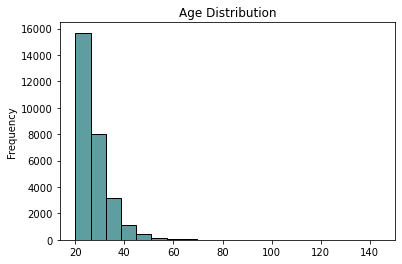

In [701]:
df["Age"].plot(kind = "hist", color = "cadetblue",ec = "k", bins = 20, title = "Age Distribution");

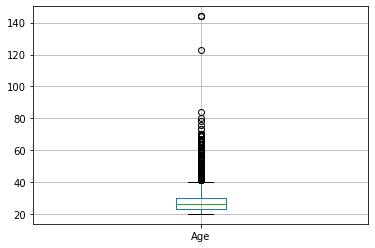

In [702]:
df.boxplot(column=['Age']);

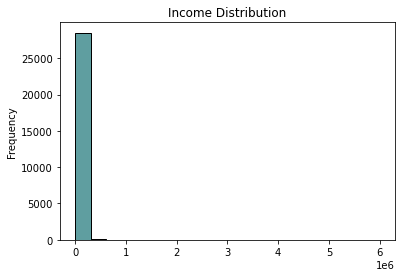

In [703]:
df["Income"].plot(kind = "hist", color = "cadetblue",ec = "k", bins = 20, title = "Income Distribution");

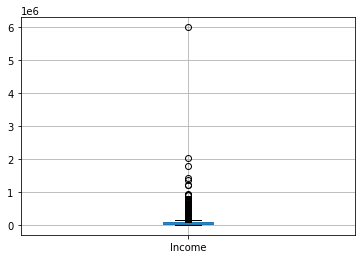

In [704]:
df.boxplot(column=['Income']);

In [705]:
print(df["Income"].median())
print(df["Income"].max())

55956.0
6000000


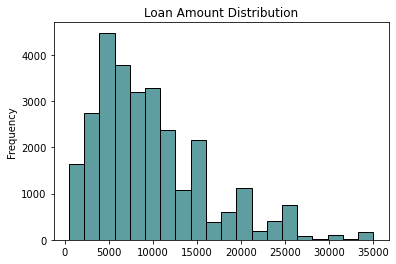

In [706]:
df["Loan_amt"].plot(kind = "hist", color = "cadetblue",ec = "k", bins = 20, title = "Loan Amount Distribution");

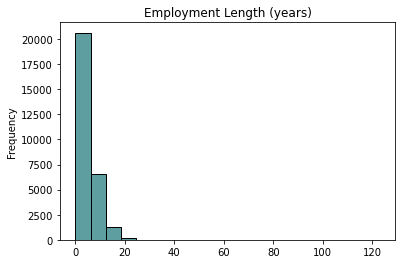

In [707]:
df["Employment"].plot(kind = "hist", color = "cadetblue",ec = "k", bins = 20, title = "Employment Length (years)");

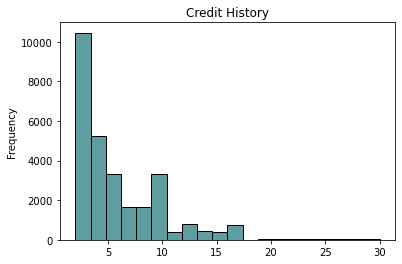

In [708]:
df["credit_hist"].plot(kind = "hist", color = "cadetblue",ec = "k", bins = 20, title = "Credit History");

In [709]:
df.describe()

,Age,Income,Employment,Loan_amt,IR,loan_status,loan_%,credit_hist
count,28638.000000,2.863800e+04,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000
mean,27.727216,6.664937e+04,4.788672,9656.493121,11.039867,0.216600,0.169488,5.793736
std,6.310441,6.235645e+04,4.154627,6329.683361,3.229372,0.411935,0.106393,4.038483
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.948000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.595600e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


* Age - most people are under 30, there is a maximum of 144 which is likely an error. There are other outliers as the data is heavily positively skewed.
* Income -  also very skewed, with median income of 56,000 and outliers with the max income of 6 million
* Employment Years - most people have less than 20 years employment 
* Loan amount - maximum is 35000, with most borrowing less than 12,000
* Credit history - the average credit history is just under 6 years with most having only 8 and a minimum of 2

## Dealing with Outliers

In [710]:
# Look at those with age over 100
df[df["Age"] > 100]

,Age,Income,Home_owner,Employment,Loan_intent,Loan_grade,Loan_amt,IR,loan_status,loan_%,default,credit_hist
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25


These do seem as though they may be mistakes especially as the employment lengths are quite low for those points and two of them are renting rather than having a mortgage. We can drop these rows.

In [711]:
df = df.drop([81,183,575,32297])

In [712]:
# Look at those with income over 1 million
df[df["Income"]>1000000]

,Age,Income,Home_owner,Employment,Loan_intent,Loan_grade,Loan_amt,IR,loan_status,loan_%,default,credit_hist
17833,32,1200000,MORTGAGE,1.0,VENTURE,A,12000,7.51,0,0.01,N,8
29119,36,1200000,OWN,16.0,MEDICAL,A,10000,6.54,0,0.01,N,11
30049,42,2039784,RENT,0.0,VENTURE,C,8450,12.29,0,0.00,Y,15
31922,47,1362000,MORTGAGE,9.0,VENTURE,A,6600,7.74,0,0.00,N,17
31924,44,1440000,MORTGAGE,7.0,DEBTCONSOLIDATION,A,6400,7.40,0,0.00,N,15
32497,63,1782000,RENT,13.0,EDUCATION,C,12025,14.27,0,0.01,N,30


The largest income of 6 million was dropped when dropping the row for an age over 100. The six rows left could be considered outliers but at the same time removing all of them makes the model less accurate for those datapoints in the future where the income is that high. The datapoint with income of 2 million is dropped.

In [713]:
df = df.drop([30049])

In [714]:
# Look at those with years of employment greater than say 40 years
df[df["Employment"]>40]

,Age,Income,Home_owner,Employment,Loan_intent,Loan_grade,Loan_amt,IR,loan_status,loan_%,default,credit_hist
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4
32355,78,48000,RENT,41.0,MEDICAL,A,3000,7.51,0,0.06,N,25


The two values over 123 years are clearly likely to be incorrect. The one that is 41 years is acceptable. Drop the two rows.

In [715]:
df = df.drop([0,210])

In [716]:
df.shape

(28631, 12)

In [717]:
# Define numerical and categorical variables
num = pd.DataFrame(df[df.select_dtypes(include=['float', 'int64']).columns])
cat = pd.DataFrame(df[df.select_dtypes(include = ['object','bool']).columns])

In [718]:
num.head()

,Age,Income,Employment,Loan_amt,IR,loan_status,loan_%,credit_hist
1,21,9600,5.0,1000,11.14,0,0.10,2
2,25,9600,1.0,5500,12.87,1,0.57,3
3,23,65500,4.0,35000,15.23,1,0.53,2
4,24,54400,8.0,35000,14.27,1,0.55,4
5,21,9900,2.0,2500,7.14,1,0.25,2


In [719]:
cat.head()

,Home_owner,Loan_intent,Loan_grade,default
1,OWN,EDUCATION,B,N
2,MORTGAGE,MEDICAL,C,N
3,RENT,MEDICAL,C,N
4,RENT,MEDICAL,C,Y
5,OWN,VENTURE,A,N


In [720]:
# one-hot encode the catogorical variables
encoded = pd.get_dummies(cat)
encoded = pd.concat([encoded, df['loan_status']], axis=1)

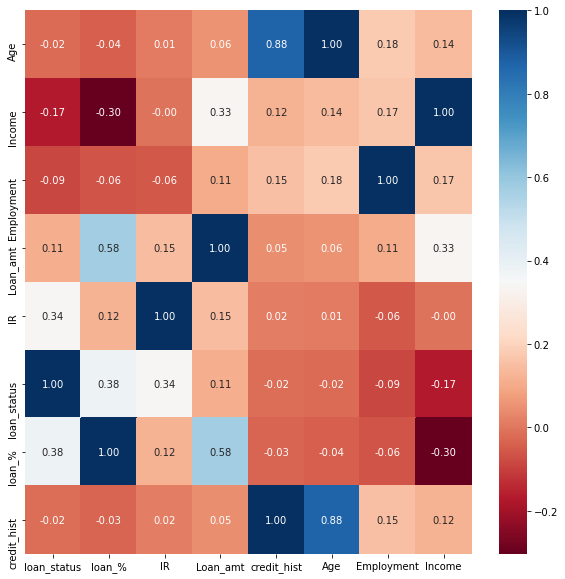

In [721]:
# Correlation of numerical values
corr = num.corr().sort_values('loan_status',axis = 1, ascending = False)
# Heatmap
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(corr, annot = True, fmt = '.2f',cmap='RdBu')

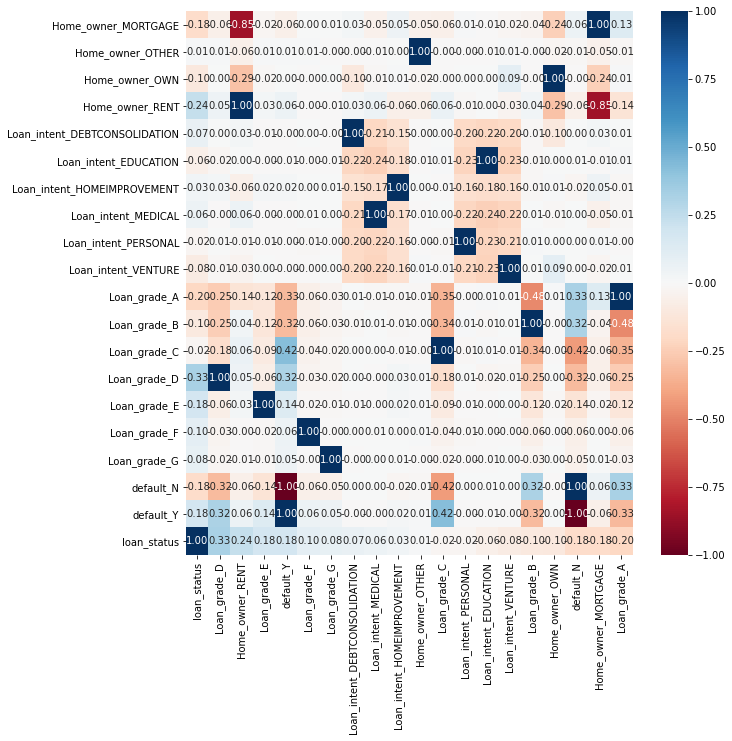

In [722]:
# Correlation of the categorical variables
corr = encoded.corr().sort_values('loan_status', axis=1, ascending=False)
# Heatmap
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(corr, annot = True, fmt = '.2f',cmap='RdBu')                                 

* there is a negative correlation between loan status and income, age and employment length, credit history, whether they are a home-owner, have a mortgage, no history of default and loan grades A to C. The higher each of these variables is the less likely a person will default.
* there is a positive correlation between loan status and loan amount, interest rate, loan percentage, whether they are renting, have a history of default and loan grade D to G. The higher these are, the more likely the person will default. 

In [723]:
# Concat the two dataframes
df_final = pd.concat([num, encoded], axis=1)
df_final.head()

,Age,Income,Employment,Loan_amt,IR,loan_status,loan_%,credit_hist,Home_owner_MORTGAGE,Home_owner_OTHER,...,Loan_grade_A,Loan_grade_B,Loan_grade_C,Loan_grade_D,Loan_grade_E,Loan_grade_F,Loan_grade_G,default_N,default_Y,loan_status
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,1,0,0,0,0,0,1,0,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,1,0,0,0,0,1,0,1
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,1,0,0,0,0,1,0,1
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,1,0,0,0,0,0,1,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,0,...,1,0,0,0,0,0,0,1,0,1


In [724]:
df_final.columns

Index(['Age', 'Income', 'Employment', 'Loan_amt', 'IR', 'loan_status',
       'loan_%', 'credit_hist', 'Home_owner_MORTGAGE', 'Home_owner_OTHER',
       'Home_owner_OWN', 'Home_owner_RENT', 'Loan_intent_DEBTCONSOLIDATION',
       'Loan_intent_EDUCATION', 'Loan_intent_HOMEIMPROVEMENT',
       'Loan_intent_MEDICAL', 'Loan_intent_PERSONAL', 'Loan_intent_VENTURE',
       'Loan_grade_A', 'Loan_grade_B', 'Loan_grade_C', 'Loan_grade_D',
       'Loan_grade_E', 'Loan_grade_F', 'Loan_grade_G', 'default_N',
       'default_Y', 'loan_status'],
      dtype='object')

In [725]:
# Drop repeated column
df_final = df_final.iloc[: , :-1]
df_final.shape

(28631, 27)

In [726]:
# Final shape
df_final.shape

(28631, 27)

In [727]:
# Split off X and y
X = df_final.drop(columns = "loan_status", axis = 1)
y = df_final["loan_status"]

In [728]:
# Check counts for y (imbalanced data so accuracy is not the best metric to use)
y.value_counts()

0    22429
1     6202
Name: loan_status, dtype: int64

As a classifier task, it would be more costly to classify a person as not likely to default when they actually do rather than classifying someone as likely to default when they are not. If defaulting is the class of interest then we would want to have the highest recall score given that the dataset is imbalanced and accuracy is not a good metric in these cases.

In [729]:
# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(22904, 26) (5727, 26) (22904,) (5727,)


In [730]:
# Define model function
def mod(model,name='Default'):
    model.fit(X_train, y_train)
    pred_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    print(name, '\n',classification_report(y_test, model.predict(X_test)))
    return pred_proba

In [731]:
# Define models to be tested
nb =  MultinomialNB()
resultnb = mod(nb, "Naive Bayes")
knn = KNeighborsClassifier()
resultknn = mod(knn, 'KNN')
lg = LogisticRegression()
resultlg = mod(lg, 'Logistic Regression')
rf = RandomForestClassifier()
resultrf = mod(rf, 'Random Forest')
xgb = XGBClassifier(use_label_encoder =False,eval_metric='mlogloss')
resultxgb = mod(xgb, 'XGBoost')

Naive Bayes 
               precision    recall  f1-score   support

           0       0.88      0.66      0.76      4533
           1       0.34      0.67      0.45      1194

    accuracy                           0.66      5727
   macro avg       0.61      0.67      0.61      5727
weighted avg       0.77      0.66      0.69      5727

KNN 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      4533
           1       0.65      0.51      0.57      1194

    accuracy                           0.84      5727
   macro avg       0.77      0.72      0.74      5727
weighted avg       0.83      0.84      0.83      5727

Logistic Regression 
               precision    recall  f1-score   support

           0       0.82      0.98      0.89      4533
           1       0.74      0.18      0.29      1194

    accuracy                           0.82      5727
   macro avg       0.78      0.58      0.59      5727
weighted avg       0.80      0.8

The best model appears to be the XGBoost with the highest recall. As the dataset is unbalanced, accuracy is not the best model but this model also has the highest accuracy.

## Confusion Matrices

In [732]:
def conf(model):
    y_pred = model.predict(X_test)
    sns.heatmap(confusion_matrix(y_test,y_pred),annot = True,fmt = ".0f")

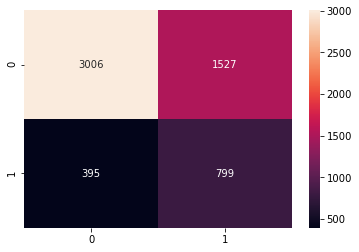

In [733]:
conf(nb)

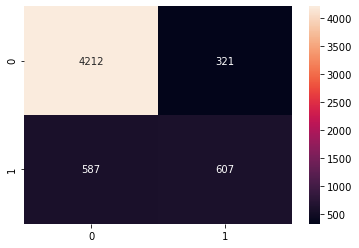

In [734]:
conf(knn)

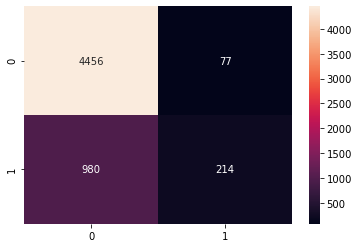

In [735]:
conf(lg)

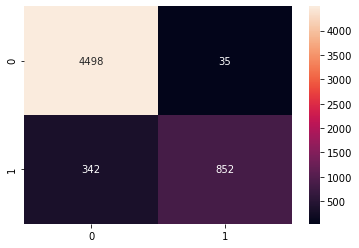

In [736]:
conf(rf)

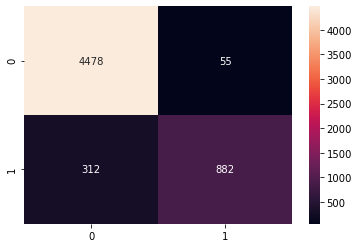

In [737]:
conf(xgb)

* It is likely that predicting someone won't default and they do is more costly in this instance than predicting someone will default when they don't. Therefore getting a good recall score is arguably more important which is the ability of the classifier to find all the positive samples (those that are likely to default). The XGBoost Classifier had the lowest number of people in the test set who actually did default when the model predicted they would not.

## ROC Curves

In [738]:
from sklearn.metrics import plot_roc_curve

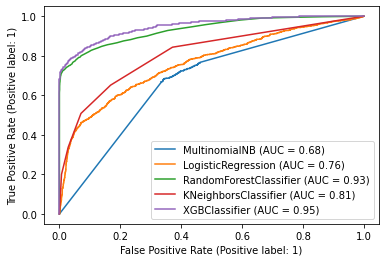

In [739]:
disp = plot_roc_curve(nb, X_test, y_test)
plot_roc_curve(lg, X_test, y_test, ax=disp.ax_)
plot_roc_curve(rf, X_test, y_test, ax=disp.ax_)
plot_roc_curve(knn, X_test,y_test, ax = disp.ax_)
plot_roc_curve(xgb, X_test, y_test, ax = disp.ax_);

In [740]:
# Best model AUROC score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])

0.9491427281269943

The highest Area under the ROC Curve score is returned by the XGBoost model.

In [741]:
# Sort the most important features from the model
feature_importance = pd.DataFrame({'feature': X_train.columns, 
                                   'importance': xgb.feature_importances_})

importance = feature_importance[feature_importance['importance']>0
                                    ].sort_values(by=['importance'],ascending=False)

importance = importance.iloc[:10]
importance

,feature,importance
10,Home_owner_RENT,0.221382
5,loan_%,0.113683
11,Loan_intent_DEBTCONSOLIDATION,0.066756
14,Loan_intent_MEDICAL,0.064123
19,Loan_grade_C,0.063118
9,Home_owner_OWN,0.061455
20,Loan_grade_D,0.050489
4,IR,0.049803
13,Loan_intent_HOMEIMPROVEMENT,0.038858
16,Loan_intent_VENTURE,0.035690


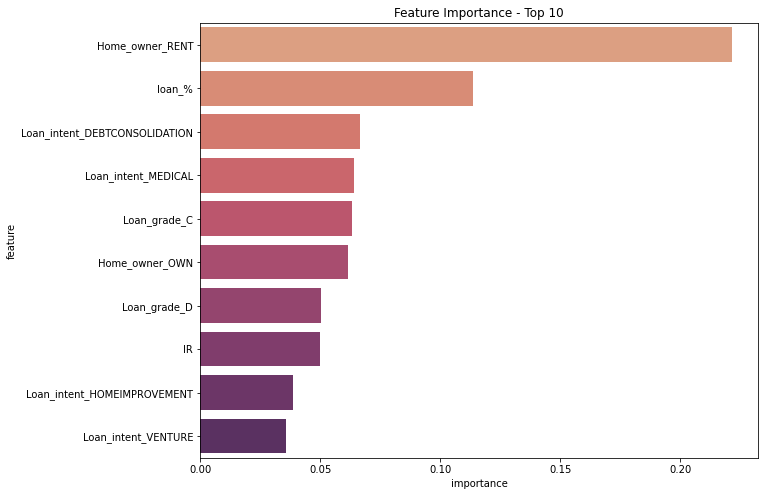

In [742]:
# View on a plot
fig, ax = plt.subplots(figsize = (10,8))
ax = sns.barplot(x = "importance", y = "feature",data = importance,palette = 'flare')
ax.set_title("Feature Importance - Top 10");

The most important feature involved with whether someone is likely to default on a loan or not is that they rent. Other factors such as size and grade of loan are also important

## Hyperparameter Tuning of the Best Model

In [743]:
# Get hyperparameters
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=20,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

## Tree architecture - min_child_weight and max_depth

In [744]:
params = {
    "max_depth": (2,3,4,5,6,8,10), # depth of each tree
    "min_child_weight": (2,3,5,6,7,8,9,10)} # smaller value produces more complex trees but can overfit
Random_CV = RandomizedSearchCV(xgb, param_distributions=params, random_state=42, 
                            n_iter=20, cv=3, verbose=2, n_jobs=16, return_train_score=True)

search = Random_CV.fit(X_train, y_train)
search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'min_child_weight': 5, 'max_depth': 6}

## Subsample and Colsample by tree

In [745]:
params = {
    "sub_sample": (0.7,0.8,0.9,1), # fraction of rows to subsample at each step
    "col_sample_bytree": (0.7,0.8,0.9,1)} # fraction of columns to subsample at each step
Random_CV = RandomizedSearchCV(xgb, param_distributions=params, random_state=42, 
                            n_iter=50, cv=3, verbose=2, n_jobs=16, return_train_score=True)

search = Random_CV.fit(X_train, y_train)
search.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[15:41:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "col_sample_bytree", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




{'sub_sample': 0.7, 'col_sample_bytree': 0.7}

## Learning Rate

In [746]:
params = {
    "eta": (.3,.2, .1, .05, .01, .005)}, # learning rate
Random_CV = RandomizedSearchCV(xgb, param_distributions=params, random_state=1, 
                            n_iter=50, cv=3, verbose=2, n_jobs=16, return_train_score=True)

search = Random_CV.fit(X_train, y_train)
search.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


{'eta': 0.3}

In [747]:
xgb = XGBClassifier(use_label_encoder =False,eval_metric='logloss',max_depth =6 , 
                    min_child_weight =5, sub_sample = 0.7, col_sample_bytree = 0.7, eta = 0.2 )

In [748]:
resultxgb = mod(xgb, 'XGBoost')

[15:41:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "col_sample_bytree", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBoost 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      4533
           1       0.96      0.74      0.83      1194

    accuracy                           0.94      5727
   macro avg       0.95      0.86      0.90      5727
weighted avg       0.94      0.94      0.94      5727



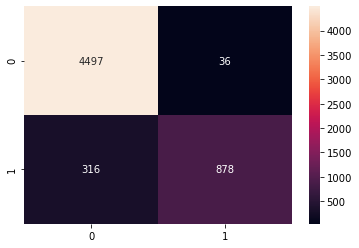

In [749]:
conf(xgb)

Increased precision a little but recall still not great

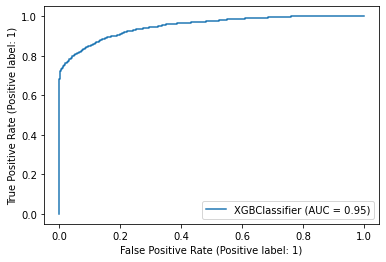

In [750]:
disp = plot_roc_curve(xgb, X_test, y_test);

In [751]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y, xgb.predict_proba(X)[:, 1])

0.9733975658816545

## Can we improve the model by dropping some features?

In [773]:
feature_importance.sort_values(by = "importance",ascending = True)

,feature,importance
25,default_Y,0.000000
22,Loan_grade_F,0.006275
6,credit_hist,0.007234
3,Loan_amt,0.008832
24,default_N,0.009574
17,Loan_grade_A,0.009739
15,Loan_intent_PERSONAL,0.009816
18,Loan_grade_B,0.011196
0,Age,0.012470
12,Loan_intent_EDUCATION,0.012934


In [759]:
df_final.columns

Index(['Age', 'Income', 'Employment', 'Loan_amt', 'IR', 'loan_status',
       'loan_%', 'credit_hist', 'Home_owner_MORTGAGE', 'Home_owner_OTHER',
       'Home_owner_OWN', 'Home_owner_RENT', 'Loan_intent_DEBTCONSOLIDATION',
       'Loan_intent_EDUCATION', 'Loan_intent_HOMEIMPROVEMENT',
       'Loan_intent_MEDICAL', 'Loan_intent_PERSONAL', 'Loan_intent_VENTURE',
       'Loan_grade_A', 'Loan_grade_B', 'Loan_grade_C', 'Loan_grade_D',
       'Loan_grade_E', 'Loan_grade_F', 'Loan_grade_G', 'default_N',
       'default_Y'],
      dtype='object')

In [783]:
# Accept only the top 20 features into the model
df_drop = df_final.drop(columns = ['default_Y','Loan_grade_F','credit_hist','Loan_amt',
                                  'default_N','Loan_grade_A','Loan_intent_PERSONAL'],axis = 1)

In [784]:
# Split off X and y
X = df_drop.drop(columns = "loan_status", axis = 1)
y = df_drop["loan_status"]

# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(22904, 19) (5727, 19) (22904,) (5727,)


In [801]:
xgb = XGBClassifier(use_label_encoder =False,eval_metric='logloss')
resultxgb = mod(xgb, 'XGBoost')

XGBoost 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      4533
           1       0.95      0.75      0.84      1194

    accuracy                           0.94      5727
   macro avg       0.94      0.87      0.90      5727
weighted avg       0.94      0.94      0.94      5727



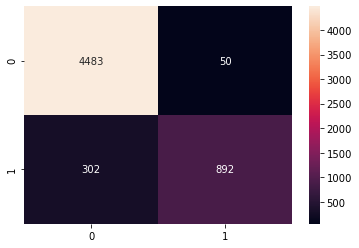

In [802]:
conf(xgb)

Dropping off the bottom 7 features increases the recall to 0.75 but precision dips a bit

In [803]:
params = {
    "max_depth": (2,3,4,5,6,8,10), # depth of each tree
    "min_child_weight": (2,3,5,6,7,8,9,10), # smaller value produces more complex trees but can overfit
    "sub_sample": (0.7,0.8,0.9,1), # fraction of rows to subsample at each step
    "col_sample_bytree": (0.7,0.8,0.9,1), # fraction of columns to subsample at each step
    "eta": (.3,.2, .1, .05, .01, .005)} # learning rate
Random_CV = RandomizedSearchCV(xgb, param_distributions=params, random_state=42, 
                            n_iter=20, cv=3, verbose=2, n_jobs=16, return_train_score=True)

search = Random_CV.fit(X_train, y_train)
search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[16:06:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "col_sample_bytree", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




{'sub_sample': 0.8,
 'min_child_weight': 2,
 'max_depth': 5,
 'eta': 0.05,
 'col_sample_bytree': 0.7}

In [804]:
xgb = XGBClassifier(use_label_encoder =False,eval_metric='logloss',max_depth =5 , 
                    min_child_weight =2, sub_sample = 0.8, col_sample_bytree = 0.7, eta = 0.05)

In [805]:
resultxgb = mod(xgb, 'XGBoost')

[16:06:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "col_sample_bytree", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBoost 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      4533
           1       0.98      0.70      0.81      1194

    accuracy                           0.93      5727
   macro avg       0.95      0.85      0.89      5727
weighted avg       0.94      0.93      0.93      5727



Tuning increased recall against the majority class but at the cost of the recall against the minority class which reduced from 0.75 to 0.70. We therefore stick with the previous model using 20 features but with default hyperparameters